####Import Libraries

In [21]:
import shutil
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from datetime import datetime, time
from sklearn.utils import resample
from matplotlib.dates import DateFormatter, AutoDateLocator
from tensorflow import keras
from keras import layers, models
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from keras.layers import LSTM, Bidirectional
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, confusion_matrix

####Set Path in Google Drive

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = os.path.join('./DS/') # Make sure to update with your student_id and student_id is an integer
GOOGLE_DRIVE_PATH = os.path.join('gdrive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print('List files: ', os.listdir(GOOGLE_DRIVE_PATH))

Mounted at /content/gdrive
List files:  ['Stress-Predict-Dataset-main.zip', 'extract', 'Input_data']


#### Read csv from Google drive and set into dictionary

In [3]:
# Name of the zip file to extract
BaseZipFolderPath=GOOGLE_DRIVE_PATH

# Set Input directory
input_folderpath=BaseZipFolderPath+'Input_data/'

# Create an empty dictionary with keys ranging from 02 to 35
id_dfs = {f"{i:02d}": None for i in range(2, 36)}

# Loop through the dictionary keys and load the corresponding CSV file
for key in id_dfs.keys():
    filename = os.path.join(input_folderpath, f"{key}.csv")
    id_dfs[key] = pd.read_csv(filename)

# Print the dictionary
print(id_dfs)

{'02':       id             datetime         X          Y          Z         BVP  \
0      2  2022-02-07 09:52:54   2.59375   4.062500  61.281250   15.760000   
1      2  2022-02-07 09:52:55  -4.46875   6.500000  63.156250  -41.960313   
2      2  2022-02-07 09:52:56  -4.12500   5.281250  63.656250   26.097031   
3      2  2022-02-07 09:52:57  -7.62500   5.468750  63.156250    4.685781   
4      2  2022-02-07 09:52:58 -14.59375   5.875000  62.281250   -7.058125   
...   ..                  ...       ...        ...        ...         ...   
3561   2  2022-02-07 10:52:15  13.43750 -33.062500  22.031250    4.830000   
3562   2  2022-02-07 10:52:16  38.12500  -5.000000  45.812500  -22.235312   
3563   2  2022-02-07 10:52:17  23.71875   6.968750  58.000000  -96.290156   
3564   2  2022-02-07 10:52:18  22.50000  -0.333333  60.333333  136.905469   
3565   2  2022-02-07 10:52:19  22.50000  -0.333333  60.333333  -16.796154   

           EDA      HR  IBI_Initial  IBI_Interval   TEMP  label  
0 

##Common functions

####Drop id column and set datetime column as index

In [4]:
#Function to drop id column and convert datetime column to index
def drop_id_datetime(df):
    # Set datetime column as index
    df = df.set_index('datetime')

    # Drop the id column
    df = df.drop('id', axis=1)

    return df

In [5]:
 #Drop id and set datetime column as index
for i in id_dfs.keys(): 
  id_dfs[i] = drop_id_datetime(id_dfs[i])

####Create sliding window

In [6]:
# Create sliding window
def sliding_window(data, window_size, step_size):
    # Create lists for windows and labels
    windows = []
    labels = []

    # Segment time series into windows
    for i in range(0, len(data)-window_size, step_size):
        window = data.iloc[i:i+window_size]
        label = window['label'].iloc[-1]
        windows.append(window.drop(['label'], axis=1).values)
        labels.append(label)

    # Prepare data for model
    X = np.array(windows)
    y = np.array(labels)

    X = X.reshape((X.shape[0], window_size, X.shape[2]))
    return X, y

#### Split data into train,validation,test sets on ratio 60:20:20 

In [7]:
#Function to create train, validation and test set while preserving the temporal aspect of the data
def create_train_val_test(X,y, train_ratio=0.6, val_ratio=0.2):
    n_train = int(train_ratio * len(X))
    n_val = int(val_ratio * len(X))
    n_test = len(X) - n_train - n_val
    
    # Split into train
    X_train = X[:n_train]
    y_train = y[:n_train]

    # Split into validation
    X_val = X[n_train:n_train+n_val]
    y_val = y[n_train:n_train+n_val]

    # Split into test
    X_test = X[n_train+n_val:]
    y_test = y[n_train+n_val:]
    
    # Display the count of train,validation and test set
    print('X Train count: ' + str(len(X_train)))
    print('y Train count: ' + str(len(y_train)))
    print('X Val count: ' + str(len(X_val)))
    print('y Val count: ' + str(len(y_val)))
    print('X Test count: ' + str(len(X_test)))
    print('y Test count: ' + str(len(y_test)))
    
    return X_train, y_train, X_val, y_val, X_test, y_test


#### Flatten the data to 2 dimensions

In [8]:
# Flatten the data to 2 dimensions
def flatten_data(X_train,X_val,X_test):
  X_train_flat = X_train.reshape((X_train.shape[0]*X_train.shape[1], X_train.shape[2]))
  X_val_flat = X_val.reshape((X_val.shape[0]*X_val.shape[1], X_val.shape[2]))
  X_test_flat = X_test.reshape((X_test.shape[0]*X_test.shape[1], X_test.shape[2]))
  return X_train_flat,X_val_flat,X_test_flat

####Normalize the data

In [9]:
#Function to Normalize the data using Standard scalar
def scale_data(X_Train,X_Val,X_Test):
  scaler = StandardScaler()
  X_train_normalized = scaler.fit_transform(X_Train)
  X_val_normalized = scaler.transform(X_Val)
  X_test_normalized = scaler.transform(X_Test)
  return X_train_normalized,X_val_normalized,X_test_normalized

#### Reshape data back to 3D array

In [10]:
# Reshape the normalized data back to 3 dimensions
def reshape_3d(X_train_norm,X_train,X_val_norm,X_val,X_test_norm,X_test):
  X_train_norm = X_train_norm.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
  X_val_norm = X_val_norm.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2]))
  X_test_norm = X_test_norm.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))
  return X_train_norm,X_val_norm,X_test_norm

####Add label back to normalized features

In [11]:
# Add label back to the normalized features
def combine_feature_label(X_train_normalized,y_train,X_val_normalized,y_val,X_test_normalized,y_test):
  train_data_norm = np.column_stack((X_train_normalized, y_train))
  val_data_norm = np.column_stack((X_val_normalized, y_val))
  test_data_norm = np.column_stack((X_test_normalized, y_test))
  return train_data_norm,val_data_norm,test_data_norm

####Evaluate model

In [25]:
def EvaluateModel(y_test,y_test_pred_model):
  # Convert probabilities to binary predictions for classification
  y_test_pred_binary = np.round(y_test_pred_model)

  # Calculate evaluation metrics
  accuracy = accuracy_score(y_test, y_test_pred_binary)
  f1 = f1_score(y_test, y_test_pred_binary)
  precision = precision_score(y_test, y_test_pred_binary)
  recall = recall_score(y_test, y_test_pred_binary)
  fp, tp, thresholds = roc_curve(y_test, y_test_pred_model)
  cm = confusion_matrix(y_test, y_test_pred_binary)

  # Plot ROC curve
  plt.plot(fp, tp)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.show()

  # Print evaluation metrics and confusion matrix
  print(f'Accuracy: {accuracy:.4f}')
  print(f'F1 score: {f1:.4f}')
  print(f'Precision: {precision:.4f}')
  print(f'Recall: {recall:.4f}')
  print(f'Confusion Matrix:\n{cm}')

####Train model1

In [13]:
def TrainModel1(train_data,y_train):
  # define parameter ranges for random search
  param_dist = {
      'n_estimators': [50, 100, 200],
      'max_features': ['auto', 'sqrt'],
      'max_depth': [10, 20, 30, None],
      'min_samples_split': [2, 5, 10],
      'min_samples_leaf': [1, 2, 4],
      'bootstrap': [True, False]
  }

  # define random search with time series cross-validation
  rfc = RandomForestClassifier()
  tscv = TimeSeriesSplit(n_splits=5)
  random_search = RandomizedSearchCV(estimator=rfc, 
                                    param_distributions=param_dist, 
                                    n_iter=20, 
                                    scoring='accuracy', 
                                    cv=tscv, 
                                    verbose=1, 
                                    n_jobs=-1)

  # fit the random search to the training data
  random_search.fit(train_data, y_train)

  # print the best hyperparameters and corresponding validation score
  print("Best parameters found: ", random_search.best_params_)

  # get the best hyperparameters
  best_params = random_search.best_params_

  # train a new random forest model using the best hyperparameters
  rfc_best = RandomForestClassifier(**best_params)
  rfc_best.fit(train_data, y_train)
  return rfc_best

####Test model1

In [14]:
# Function to test the model on validation and test set
def TestModel1(model1,val_data_norm,test_data_norm):
  y_val_pred_model1 = model1.predict(val_data_norm)
  y_test_pred_model1 = model1.predict(test_data_norm)
  return y_val_pred_model1,y_test_pred_model1

####Train model2

In [15]:
def TrainModel2(X_train_win,y_train_win,X_val_win,y_val_win,window_size):
  # reset the TensorFlow graph
  tf.keras.backend.clear_session()

  # Define the model
  num_features = X_train.shape[2]
  model = Sequential()
  model.add(LSTM(16, input_shape=(window_size, num_features)))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  # train the model
  history = model.fit(X_train_win, y_train_win, validation_data=(X_val_win, y_val_win), epochs=20, batch_size=64)

  return history,model

####Test model2

In [16]:
def TestModel2(model,X_test_win):
  y_pred_probability = model.predict(X_test_win)
  y_test_pred_model2 = (y_pred_probability > 0.5).astype(int)
  return y_test_pred_model2

####Train model3

In [17]:
def TrainModel3(X_train, y_train, X_val, y_val,window_size):
  # Reset the TensorFlow graph
  tf.keras.backend.clear_session()

  num_features = X_train.shape[2]
  model = Sequential()
  model.add(Bidirectional(LSTM(16), input_shape=(window_size, num_features)))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  # train the model
  history = model.fit(X_train, y_train, validation_data=(y_train, y_val), epochs=20, batch_size=64)  

  return history, model

Test model3

In [18]:
def TestModel3(model,X_test_win):
  y_pred_probability = model.predict(X_test_win)
  y_test_pred_model2 = (y_pred_probability > 0.5).astype(int)
  return y_test_pred_model2

####Plot loss

In [19]:
def plot_loss(history):
    # Plot model loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    # Add labels and legend
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Val'], loc='upper right')

    # Show the plot
    plt.show()

##Execute the functions

----------------------------------------------------------------------------***********Start**********----------------------------------------------------------------------------------------------------------
Results for participant:02
X Train count: 2139
y Train count: 2139
X Val count: 713
y Val count: 713
X Test count: 714
y Test count: 714
**********************************************************************************Model1 : Random forest***************************************************************************************
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}


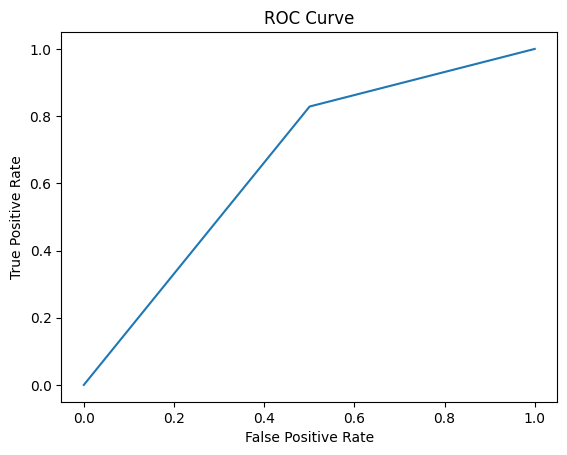

Accuracy: 0.5154
F1 score: 0.1436
Precision: 0.0786
Recall: 0.8286
Confusion Matrix:
[[339 340]
 [  6  29]]
**********************************************************************************Model2 : LSTM****************************************************************************************
X Train count: 210
y Train count: 210
X Val count: 70
y Val count: 70
X Test count: 71
y Test count: 71
Epoch 1/20
4/4 [==============================] - 5s 388ms/step - loss: 0.8057 - accuracy: 0.3952 - val_loss: 0.7235 - val_accuracy: 0.4429
Epoch 2/20
4/4 [==============================] - 0s 47ms/step - loss: 0.7795 - accuracy: 0.4095 - val_loss: 0.7243 - val_accuracy: 0.4714
Epoch 3/20
4/4 [==============================] - 0s 46ms/step - loss: 0.7511 - accuracy: 0.4286 - val_loss: 0.7249 - val_accuracy: 0.5143
Epoch 4/20
4/4 [==============================] - 0s 48ms/step - loss: 0.7288 - accuracy: 0.5000 - val_loss: 0.7255 - val_accuracy: 0.5429
Epoch 5/20
4/4 [==============================]

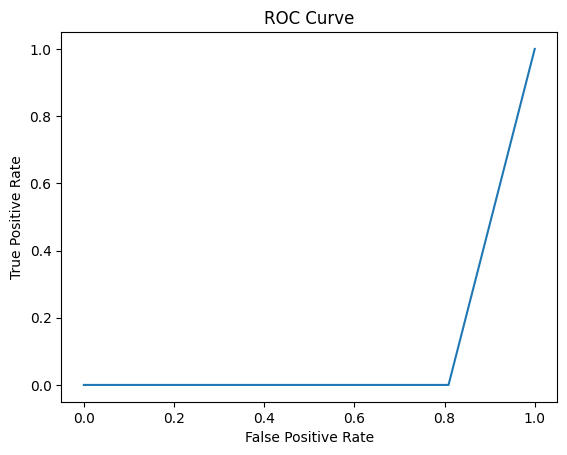

Accuracy: 0.1831
F1 score: 0.0000
Precision: 0.0000
Recall: 0.0000
Confusion Matrix:
[[13 55]
 [ 3  0]]


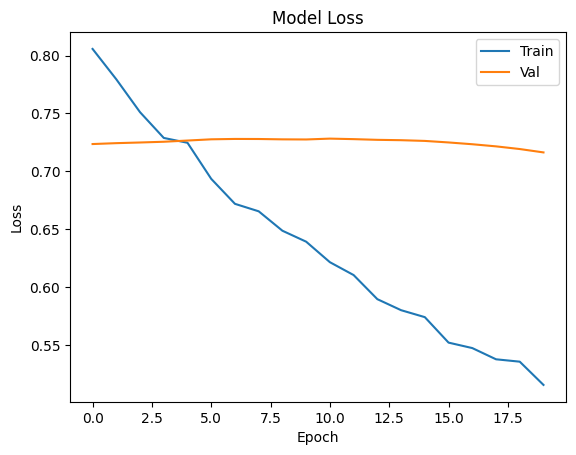

*********************************************************************************Model3 : BiLSTM*******************************************************************************************************
Epoch 1/20
4/4 [==============================] - 3s 243ms/step - loss: 0.6803 - accuracy: 0.5952 - val_loss: 0.6896 - val_accuracy: 0.4714
Epoch 2/20
4/4 [==============================] - 0s 44ms/step - loss: 0.6786 - accuracy: 0.5238 - val_loss: 0.6909 - val_accuracy: 0.4571
Epoch 3/20
4/4 [==============================] - 0s 39ms/step - loss: 0.6600 - accuracy: 0.6000 - val_loss: 0.6921 - val_accuracy: 0.4571
Epoch 4/20
4/4 [==============================] - 0s 40ms/step - loss: 0.6428 - accuracy: 0.6762 - val_loss: 0.6933 - val_accuracy: 0.4429
Epoch 5/20
4/4 [==============================] - 0s 40ms/step - loss: 0.6355 - accuracy: 0.6857 - val_loss: 0.6946 - val_accuracy: 0.4429
Epoch 6/20
4/4 [==============================] - 0s 41ms/step - loss: 0.6260 - accuracy: 0.7286 - val_l

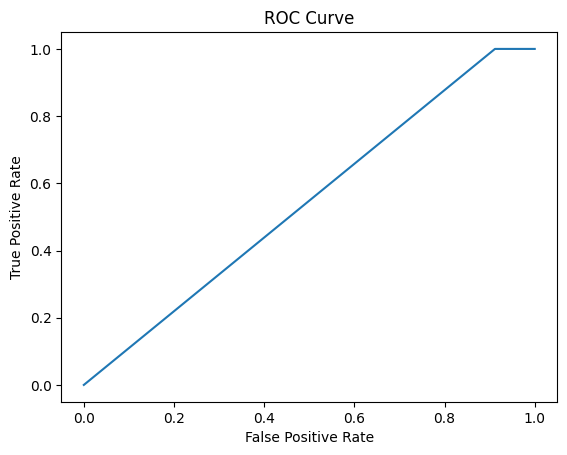

Accuracy: 0.1268
F1 score: 0.0882
Precision: 0.0462
Recall: 1.0000
Confusion Matrix:
[[ 6 62]
 [ 0  3]]


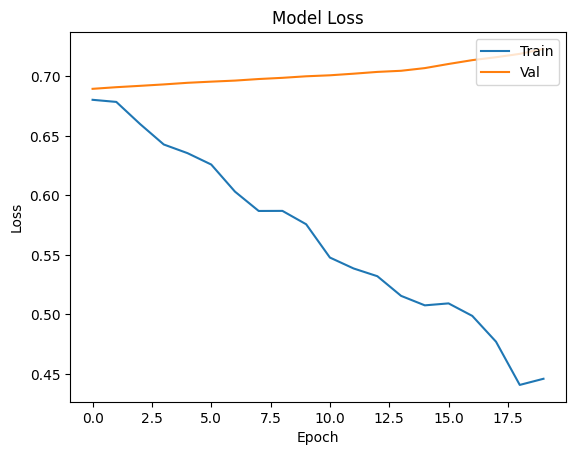

-----------------------------------------------------------------------------************End****************-----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------***********Start**********----------------------------------------------------------------------------------------------------------
Results for participant:03
X Train count: 1990
y Train count: 1990
X Val count: 663
y Val count: 663
X Test count: 665
y Test count: 665
**********************************************************************************Model1 : Random forest***************************************************************************************
Fitting 5 folds for each of 20 candidates, totalling 100 fits


KeyboardInterrupt: ignored

In [26]:
#Sliding window concept is applied on neural network models : Model2:LSTM and Model3: BiLSTM,   
#Sliding window concept not applied for model1: randomforest


#Execute function
windows=['without_sliding_window','with_sliding_window']
for i in id_dfs.keys():
  for window in windows:
    if window=='without_sliding_window':
      print('----------------------------------------------------------------------------***********Start**********----------------------------------------------------------------------------------------------------------')
      print('Results for participant:'+i)
      
      # Separate X and y
      X = id_dfs[i].drop('label', axis=1)  # drop the 'label' column to create the feature matrix
      y = id_dfs[i]['label'] 

      #Split the data
      X_train, y_train, X_val, y_val, X_test, y_test = create_train_val_test(X,y)

      #Normalize the data
      X_train_normalized,X_val_normalized,X_test_normalized=scale_data(X_train,X_val,X_test)

      print('**********************************************************************************Model1 : Random forest***************************************************************************************')
      #Train model 1
      model1=TrainModel1(X_train_normalized,y_train)

      #Test model 1
      y_val_pred_model1,y_test_pred_model1=TestModel1(model1,X_val_normalized,X_test_normalized)

      #Evaluate model 1
      EvaluateModel(y_test,y_test_pred_model1)
      print('**********************************************************************************Model2 : LSTM****************************************************************************************')
    else:
      #Set Window size and step size
      window=60
      step_size=10

      #Sliding window
      X, y=sliding_window(id_dfs[i], window, step_size)

      #Split the data
      X_train, y_train, X_val, y_val, X_test, y_test = create_train_val_test(X,y)

      #Flatten the array to 2D array from 3D array
      X_train_flat,X_val_flat,X_test_flat=flatten_data(X_train,X_val,X_test)

      #Scale the data
      X_train_normalized,X_val_normalized,X_test_normalized=scale_data(X_train_flat,X_val_flat,X_test_flat)

      #Reshape the data from 2D array back to 3Darray
      X_train_reshape,X_val_reshape,X_test_reshape=reshape_3d(X_train_normalized,X_train,X_val_normalized,X_val,X_test_normalized,X_test)

      #Train model 2
      history_2,model2=TrainModel2(X_train_reshape,y_train,X_val_reshape,y_val,window)

      #Test model 2
      y_test_pred_model2=TestModel2(model2,X_test_reshape)

      #Evaluate model 2
      EvaluateModel(y_test,y_test_pred_model2)
      plot_loss(history_2)

      print('*********************************************************************************Model3 : BiLSTM*******************************************************************************************************')
      #Train model 3
      history_3,model3=TrainModel2(X_train_reshape,y_train,X_val_reshape,y_val,window)

      #Test model 3
      y_test_pred_model3=TestModel2(model3,X_test_reshape)

      #Evaluate model 3
      EvaluateModel(y_test,y_test_pred_model3)
      plot_loss(history_3)
      print('-----------------------------------------------------------------------------************End****************-----------------------------------------------------------------------------------------------')